# Solution Visualization: 3D

## Description
Notebook of optimization algorithm solutions superimposed on 3d surface plots.

In [1]:
import json
import os

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Test Functions

In [2]:
def rosenbrock(x):
    """
    rosenbrock evaluates Rosenbrock function at vector x

    Parameters
    ----------
    x : array
        x is a D-dimensional vector, [x1, x2, ..., xD]

    Returns
    -------
    float
        scalar result
    """
    D = len(x)
    i, iplus1 = np.arange(0,D-1), np.arange(1,D)
    return np.sum(100*(x[iplus1] - x[i]**2)**2 + (1-x[i])**2)


def goldstein_price(x):
    """
    goldstein_price evaluates Goldstein-Price function at vector x

    Parameters
    ----------
    x : array
        x is a 2-dimensional vector, [x1, x2]

    Returns
    -------
    float
        scalar result
    """
    a = (x[0] + x[1] + 1)**2
    b = 19 - 14*x[0] + 3*x[0]**2 - 14*x[1] + 6*x[0]*x[1] + 3*x[1]**2
    c = (2*x[0] - 3*x[1])**2
    d = 18 - 32*x[0] + 12*x[0]**2 + 48*x[1] - 36*x[0]*x[1] + 27*x[1]**2
    return (1. + a*b) * (30. + c*d)


def bartels_conn(x):
    """
    bartels_conn evaluates Bartels-Conn function at vector x

    Parameters
    ----------
    x : array
        x is a 2-dimensional vector, [x1, x2]

    Returns
    -------
    float
        scalar result
    """
    a = np.abs(x[0]**2 + x[1]**2 + x[0]*x[1])
    b = np.abs(np.sin(x[0]))
    c = np.abs(np.cos(x[1]))
    return a + b +c


def egg_crate(x):
    """
    egg_crate evaluates Egg Crate function at vector x

    Parameters
    ----------
    x : array
        x is a 2-dimensional vector, [x1, x2]

    Returns
    -------
    float
        scalar result
    """
    return x[0]**2 + x[1]**2 + 25.*(np.sin(x[0])**2 + np.sin(x[1])**2)

## Surface Generation

In [3]:
def surface(fx, start=-30, stop=30, num=60):
    """
    surface evaluates fx at regularly spaced grid of points

    Parameters
    ----------
    fx : func
        fx is a vector valued function that returns a scalar result
    start : float
        lower bound of the coordinate grid
    stop : float
        upper bound of the coordinate grid
    num : int
        number of points along one dimension of the grid

    Returns
    -------
    array
        2D array formed by evaluating fx at each grid point
    """
    x = np.linspace(start=start, stop=stop, num=num)
    x1, x2 = np.meshgrid(x, x, indexing='ij')
    X = np.vstack((x1.ravel(), x2.ravel()))
    z = np.apply_along_axis(fx, 0, X).reshape(num,num)
    return x1, x2, z

## Solution Results

In [4]:
def load_steps(**params):
    """Return solution steps based on simulation properties."""
    savefn = os.path.join(params['base_dirn'],
                          params['savefn_fmt'].format(**params))
    return np.load(savefn)


def load_meta(**params):
    """Return metafile based on simulation properties."""
    metafn = os.path.join(params['base_dirn'],
                          params['metafn_fmt'].format(**params))
    return json.load(open(metafn, 'r'))


def plot3d_solutions(**params):
    """
    plot3d_solutions creates 3d solution plot from simulation results
    """
    algstr = params['alg'].replace('_',' ').title()
    funcstr = params['func'].replace('_',' ').title()
    bounds = params['bounds']
    elev = params['elev']
    azim = params['azim']
    trials = params['trials']
    nsamples = params['nsamples']
    xkmind = params.get('xkmind', slice(2))
    marker = params.get('marker', '.')
    color = params.get('color', 'crimson') 
    show_legend = params.get('show_legend', True)
    
    # Imbue title with simulation meta information.
    meta = load_meta(**params)
    expmin, expxkmin = meta['exp_fxkmin'], meta['exp_xkmin']
    expminstr = 'abs $\\min(f)$={0:.0f}'.format(expmin)
    algstr = algstr if len(algstr) > 4 else algstr.upper()
    algmeta = [('nx0','n'),('T0','$T_0$'),
               ('alpha','$\\alpha$'),('tol','tol')]
    algmetastr = ' '.join(['{0}={1}'.format(n2, meta[n1])
                           for n1, n2 in algmeta if n1 in meta])
    nitstr = 'nit={0:d}'.format(meta['nsteps'][trials[0]-1])
    minfx = meta['f(xk)'][trials[0]-1]
    minfmt = '.2e' if minfx < 1e-1 else '.1f'
    minstr = '$\\min(f)$={0:{1}}'.format(minfx, minfmt)

    # Generate surface for filled contour plot.
    fx = globals()[params['func']]
    start, stop = np.min(bounds[::2]), np.max(bounds[1::2])
    x1, x2, z = surface(fx, start, stop, params['ngridpts'])

    fig = plt.figure(figsize=(10,8))
    ax = fig.gca(projection='3d')
    ax.view_init(elev=elev, azim=azim)
    surf = ax.plot_surface(x1, x2, z, cmap='viridis_r', alpha=0.7)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.scatter3D([expxkmin[0]],[expxkmin[1]], [expmin],
                 marker='D', c='black', s=40,
                 label=expminstr, alpha=1.0)
    for trial in trials:
        steps = load_steps(**params, trial=trial)
        samples = np.linspace(0,len(steps)-1,nsamples,dtype=int)
        xks = steps[samples,xkmind]
        xks = np.clip(xks, a_min=bounds[::2], a_max=bounds[1::2])
        ax.plot3D([xk[0] for xk in xks],
                  [xk[1] for xk in xks],
                  [fx(xk) for xk in xks],
                  marker=marker, c=color, alpha=1.0,
                  label='$x_k$, trial={:d}'.format(trial))
    plt.suptitle('Solution Trajectories: {0} Function'.format(funcstr))
    plt.title('{0} {1} {2} {3}'.format(algstr, minstr, nitstr,
                                       algmetastr))
    plt.xlabel('x1')
    plt.xlim(bounds[:2])
    plt.ylabel('x2')
    plt.ylim(bounds[2:])
    if show_legend:
        ax.legend()
    plt.show()

## Solutions: Rosenbrock Function

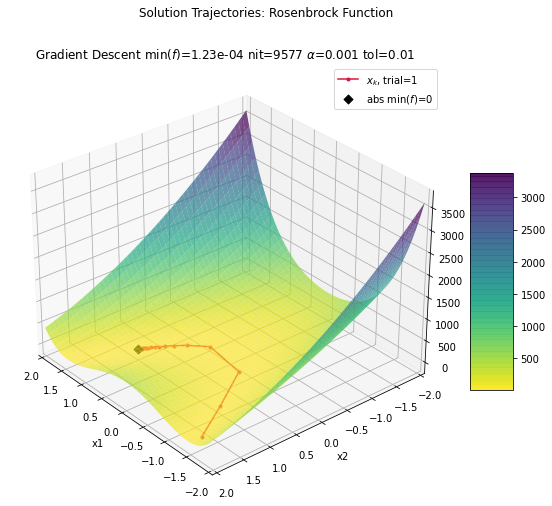

In [5]:
params = {
    'alg': 'gradient_descent',
    'func': 'rosenbrock',
    'trials': [1],
    'base_dirn': './sims/',
    'savefn_fmt': '{alg}-{func}-steps-{trial:02d}.npy',
    'metafn_fmt': '{alg}-{func}-meta.json',
    'bounds': [-2.,2.,-2.,2.],
    'elev': 30,
    'azim': 140,
    'ngridpts': 500,
    'nsamples': 20,
}

plot3d_solutions(**params)

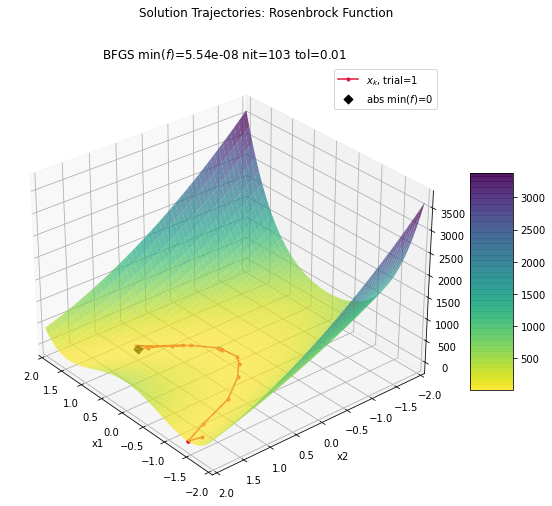

In [6]:
params = {
    'alg': 'bfgs',
    'func': 'rosenbrock',
    'trials': [1],
    'base_dirn': './sims/',
    'savefn_fmt': '{alg}-{func}-steps-{trial:02d}.npy',
    'metafn_fmt': '{alg}-{func}-meta.json',
    'bounds': [-2.,2.,-2.,2.],
    'elev': 30,
    'azim': 140,
    'ngridpts': 500,
    'nsamples': 20,
}

plot3d_solutions(**params)

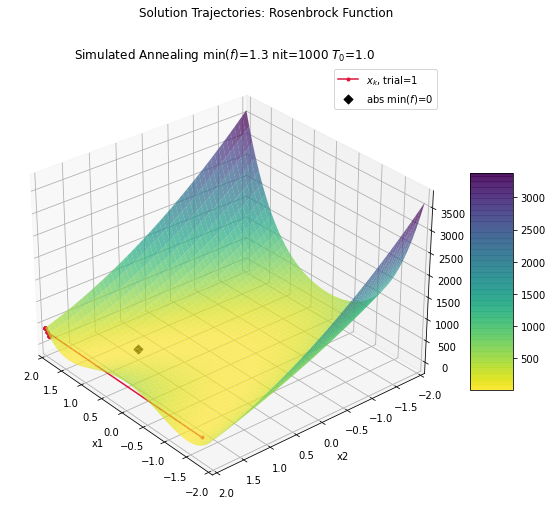

In [7]:
params = {
    'alg': 'simulated_annealing',
    'func': 'rosenbrock',
    'trials': [1],
    'base_dirn': './sims/',
    'savefn_fmt': '{alg}-{func}-steps-{trial:02d}.npy',
    'metafn_fmt': '{alg}-{func}-meta.json',
    'bounds': [-2.,2.,-2.,2.],
    'elev': 30,
    'azim': 140,
    'ngridpts': 500,
    'nsamples': 20,
    'xkmind': slice(3,5),
}

plot3d_solutions(**params)

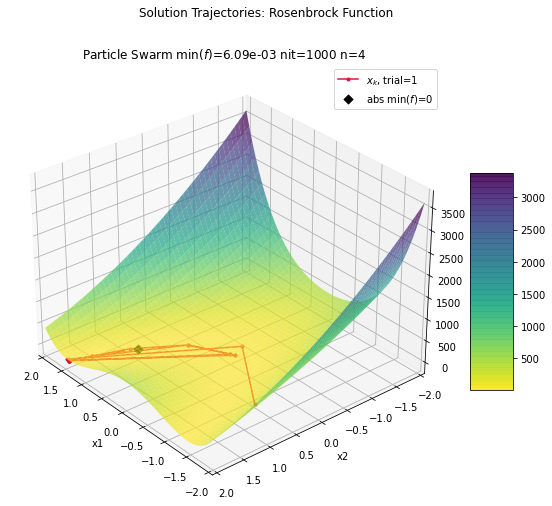

In [8]:
params = {
    'alg': 'particle_swarm',
    'func': 'rosenbrock',
    'trials': [1],
    'base_dirn': './sims/',
    'savefn_fmt': '{alg}-{func}-steps-{trial:02d}.npy',
    'metafn_fmt': '{alg}-{func}-meta.json',
    'bounds': [-2.,2.,-2.,2.],
    'elev': 30,
    'azim': 140,
    'ngridpts': 500,
    'nsamples': 20,
    'xkmind': slice(4,6),
}

plot3d_solutions(**params)

## Solutions: Goldstein-Price Function

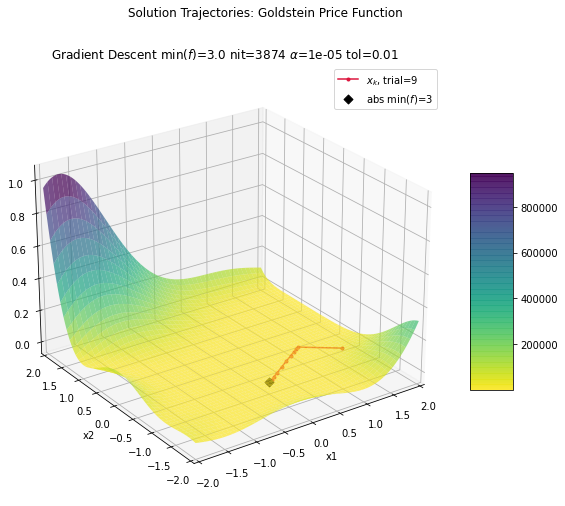

In [19]:
params = {
    'alg': 'gradient_descent',
    'func': 'goldstein_price',
    'trials': [9],
    'base_dirn': './sims/',
    'savefn_fmt': '{alg}-{func}-steps-{trial:02d}.npy',
    'metafn_fmt': '{alg}-{func}-meta.json',
    'bounds': [-2.,2.,-2.,2.],
    'elev': 25,
    'azim': 235,
    'ngridpts': 500,
    'nsamples': 20,
}

plot3d_solutions(**params)

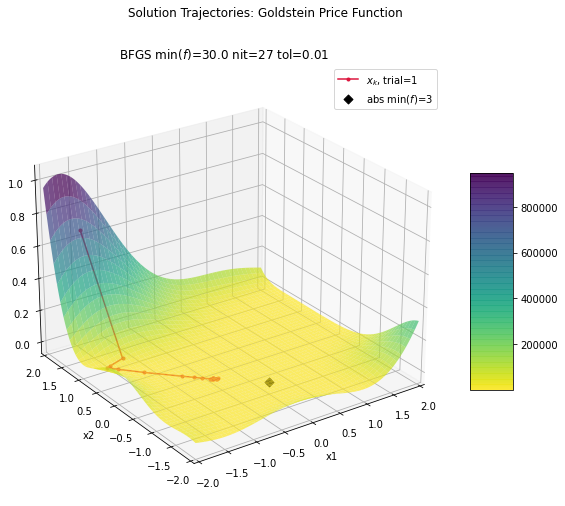

In [10]:
params = {
    'alg': 'bfgs',
    'func': 'goldstein_price',
    'trials': [1],
    'base_dirn': './sims/',
    'savefn_fmt': '{alg}-{func}-steps-{trial:02d}.npy',
    'metafn_fmt': '{alg}-{func}-meta.json',
    'bounds': [-2.,2.,-2.,2.],
    'elev': 25,
    'azim': 235,
    'ngridpts': 500,
    'nsamples': 20,
}

plot3d_solutions(**params)

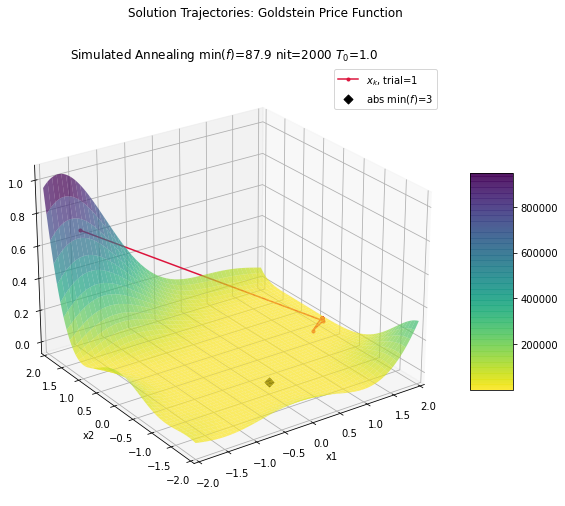

In [11]:
params = {
    'alg': 'simulated_annealing',
    'func': 'goldstein_price',
    'trials': [1],
    'base_dirn': './sims/',
    'savefn_fmt': '{alg}-{func}-steps-{trial:02d}.npy',
    'metafn_fmt': '{alg}-{func}-meta.json',
    'bounds': [-2.,2.,-2.,2.],
    'elev': 25,
    'azim': 235,
    'ngridpts': 500,
    'nsamples': 20,
    'xkmind': slice(3,5),
}

plot3d_solutions(**params)

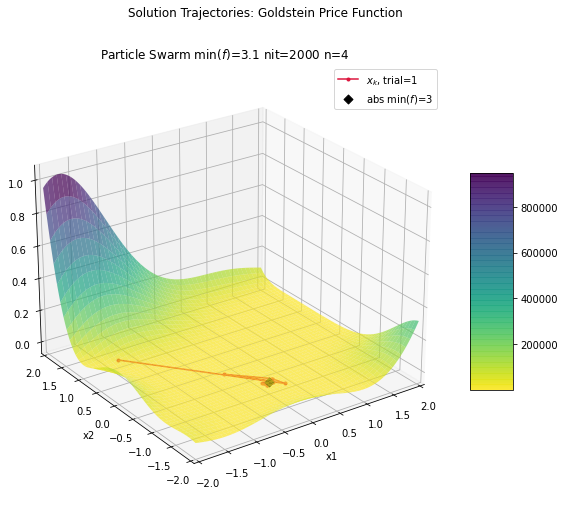

In [12]:
params = {
    'alg': 'particle_swarm',
    'func': 'goldstein_price',
    'trials': [1],
    'base_dirn': './sims/',
    'savefn_fmt': '{alg}-{func}-steps-{trial:02d}.npy',
    'metafn_fmt': '{alg}-{func}-meta.json',
    'bounds': [-2.,2.,-2.,2.],
    'elev': 25,
    'azim': 235,
    'ngridpts': 500,
    'nsamples': 20,
    'xkmind': slice(4,6),
}

plot3d_solutions(**params)

## Solutions: Bartels-Conn

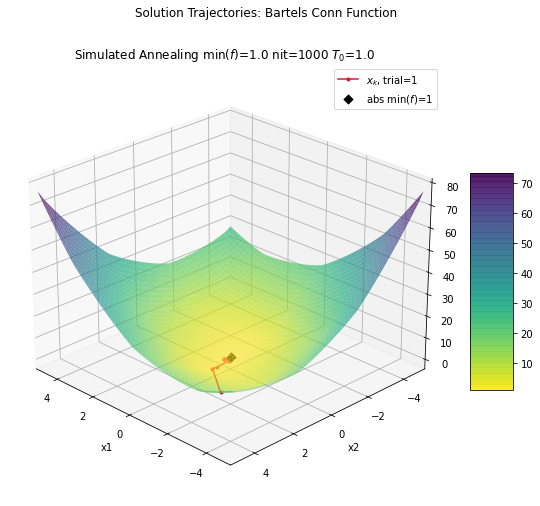

In [13]:
params = {
    'alg': 'simulated_annealing',
    'func': 'bartels_conn',
    'trials': [1],
    'base_dirn': './sims/',
    'savefn_fmt': '{alg}-{func}-steps-{trial:02d}.npy',
    'metafn_fmt': '{alg}-{func}-meta.json',
    'bounds': [-5.,5.,-5.,5.],
    'elev': 25,
    'azim': 135,
    'ngridpts': 500,
    'nsamples': 20,
    'xkmind': slice(3,5),
}

plot3d_solutions(**params)

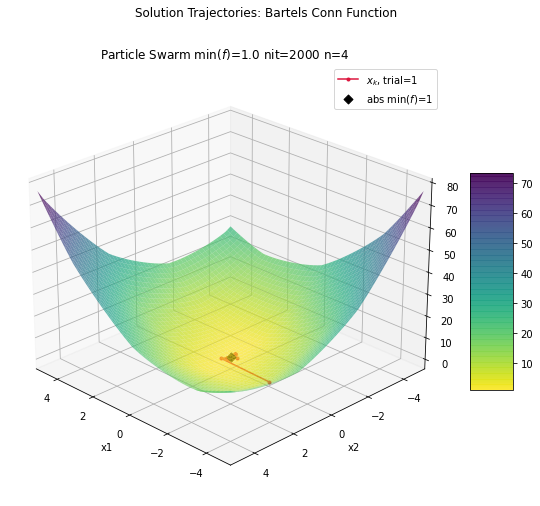

In [14]:
params = {
    'alg': 'particle_swarm',
    'func': 'bartels_conn',
    'trials': [1],
    'base_dirn': './sims/',
    'savefn_fmt': '{alg}-{func}-steps-{trial:02d}.npy',
    'metafn_fmt': '{alg}-{func}-meta.json',
    'bounds': [-5.,5.,-5.,5.],
    'elev': 25,
    'azim': 135,
    'ngridpts': 500,
    'nsamples': 20,
    'xkmind': slice(4,6),
}

plot3d_solutions(**params)

## Solutions: Egg Crate

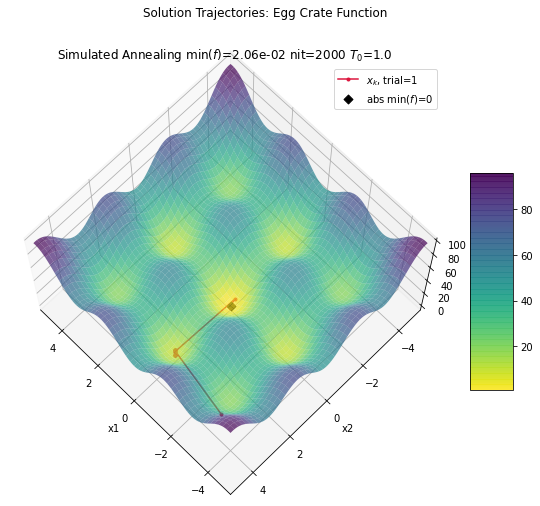

In [15]:
params = {
    'alg': 'simulated_annealing',
    'func': 'egg_crate',
    'trials': [1],
    'base_dirn': './sims/',
    'savefn_fmt': '{alg}-{func}-steps-{trial:02d}.npy',
    'metafn_fmt': '{alg}-{func}-meta.json',
    'bounds': [-5.,5.,-5.,5.],
    'elev': 70,
    'azim': 135,
    'ngridpts': 500,
    'nsamples': 20,
    'xkmind': slice(3,5),
}

plot3d_solutions(**params)

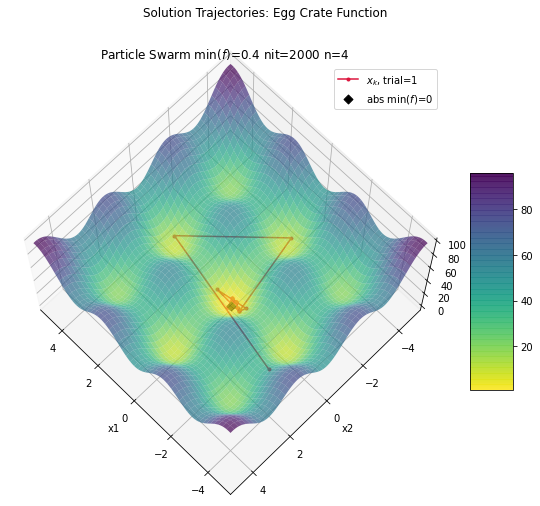

In [16]:
params = {
    'alg': 'particle_swarm',
    'func': 'egg_crate',
    'trials': [1],
    'base_dirn': './sims/',
    'savefn_fmt': '{alg}-{func}-steps-{trial:02d}.npy',
    'metafn_fmt': '{alg}-{func}-meta.json',
    'bounds': [-5.,5.,-5.,5.],
    'elev': 70,
    'azim': 135,
    'ngridpts': 500,
    'nsamples': 20,
    'xkmind': slice(4,6),
}

plot3d_solutions(**params)